# EAKF

In [28]:
import time
import scipy.stats
import numpy as np


def fOde(theta, x):
    """
    theta: list[4]: beta, ve, vi, pd
    x: array(n, 4)
    r: array(n, 2)
    """
    global N
    logS = x[:, 0]
    logE = x[:, 1]
    logI = x[:, 2]
    logD = x[:, 3]
    logSdt = -theta[:, 0] * np.exp(logI) / N  # (1)
    logEdt = theta[:, 0] * np.exp(logS + logI - logE) / N - theta[:, 1]  # (2)
    logIdt = np.exp(logE - logI) * theta[:, 1] - theta[:, 2]  # (3)
    logDdt = np.exp(logI - logD) * theta[:, 3] * theta[:, 2] * 0.25  # (4)
    return np.stack([logSdt, logEdt, logIdt, logDdt], axis=1)



N = 100000
obs_per_day = 1
time_ls = np.zeros(100)
days = 32
discretization = 1
eakf_ls = np.zeros((100, days * discretization, 4))
for EachRep in range(100):
    print(EachRep)
    start_time = time.time()
    SEED = np.random.randint(1, 100000)
    np.random.seed(SEED)
    yobs = np.load('SEIRD observations.npy')[EachRep]
    ydata = yobs.copy()
    ydata[:, 1] = np.interp(np.arange(0, days, 1), np.arange(0, days, 2), yobs[::2, 1])
    tvecObs = np.arange(0, 32, 1)
    tvecFull = np.arange(0, 32, 1)
    yFull = np.ndarray([days * discretization, ydata.shape[1]])
    yFull.fill(np.nan)
    yFull[np.arange(0, days * discretization, discretization).astype(int), :] = ydata
    xInitExogenous = np.zeros_like(yFull)
    for j in range(ydata.shape[1]):
        xInitExogenous[:, j] = np.interp(tvecFull, tvecObs, ydata[:, j])

    noise = 0.2
    dim_x = 4
    dim_theta = 4
    prior_mean_x0 = np.array([yFull[0, 0], yFull[0, 1], yFull[0, 2], yFull[0, 3]])
    prior_variance_x0 = np.diag([noise ** 2, noise ** 2, noise ** 2, noise ** 2])
    prior_mean_theta = np.array([1.8, 0.1, 0.1, 0.2])
    prior_variance_theta = np.diag([1., 1., 1., 1.])
    var_obs_error = np.diag([noise ** 2, noise ** 2, noise ** 2, noise ** 2])
    outlier_threshold = 0.03

    theta_roaming_variance_unit_time = np.diag([0.1, 0.05, 0.01, 0.05])

    simulation_size = 100000
    samples_x = np.zeros(shape=[yFull.shape[0], simulation_size, dim_x])
    samples_theta = np.zeros(shape=[yFull.shape[0], simulation_size, dim_theta])

    init_samples_x = np.random.multivariate_normal(prior_mean_x0, prior_variance_x0, simulation_size)
    init_samples_theta = np.random.multivariate_normal(prior_mean_theta, prior_variance_theta, simulation_size)

    samples_x[0] = init_samples_x
    samples_theta[0] = init_samples_theta

    for k in range(1, yFull.shape[0]):
        delta_t = tvecFull[k] - tvecFull[k-1]

        samples_pred_theta = samples_theta[k-1] + np.random.multivariate_normal(np.zeros(dim_theta), theta_roaming_variance_unit_time * delta_t, simulation_size)
        samples_pred_theta = np.asarray(scipy.stats.mstats.winsorize(samples_pred_theta, outlier_threshold))

        samples_pred_x = samples_x[k-1] + delta_t * fOde(samples_pred_theta, samples_x[k-1])
        samples_pred_x = np.asarray(scipy.stats.mstats.winsorize(samples_pred_x, outlier_threshold))

        if not np.any(np.isfinite(yFull[k, :])):
            samples_x[k] = samples_pred_x
            samples_theta[k] = samples_pred_theta
        else:
            yobs = yFull[k, :]

            # deterministic updates
            samples_pred_xtheta = np.hstack([samples_pred_x, samples_pred_theta])
            mean_pred_xtheta = np.mean(samples_pred_xtheta, axis=0)

            var_pred_y = np.cov(samples_pred_x.transpose()) + var_obs_error

            var_pred_xtheta = np.cov(samples_pred_xtheta.transpose())
            cov_pred_xtheta_y = var_pred_xtheta[:, :dim_x]
            mean_pred_y = mean_pred_xtheta[:dim_x]

            idx_yobs = np.isfinite(yobs)
            yobs = yobs[idx_yobs]
            var_pred_y = var_pred_y[idx_yobs, :][:, idx_yobs]
            cov_pred_xtheta_y = cov_pred_xtheta_y[:, idx_yobs]
            mean_pred_y = mean_pred_y[idx_yobs]

            invvar_pred_y = np.linalg.inv(var_pred_y)

            mean_cond_xtheta = mean_pred_xtheta + (cov_pred_xtheta_y @ invvar_pred_y @ (yobs - mean_pred_y))
            var_cond_xtheta = var_pred_xtheta - (cov_pred_xtheta_y @ invvar_pred_y @ cov_pred_xtheta_y.transpose())

            eigval, eigmat = np.linalg.eig(var_pred_xtheta)
            matsqrt_var_pred_xtheta = eigmat @ np.diag(np.sqrt(eigval)) @ eigmat.transpose()
            eigval, eigmat = np.linalg.eig(var_cond_xtheta)
            matsqrt_var_cond_xtheta = eigmat @ np.diag(np.sqrt(eigval)) @ eigmat.transpose()

            samples_cond_xtheta = mean_cond_xtheta.reshape([-1, 1]) + matsqrt_var_cond_xtheta @ np.linalg.inv(matsqrt_var_pred_xtheta) @ (samples_pred_xtheta.transpose() - mean_pred_xtheta.reshape([-1, 1]))
            samples_cond_xtheta = samples_cond_xtheta.transpose()

            samples_x[k] = samples_cond_xtheta[:, :dim_x]
            samples_theta[k] = samples_cond_xtheta[:, dim_x:]
    eakf_ls[EachRep] = np.mean(samples_theta, axis=1)
    time_ls[EachRep] = time.time() - start_time
    
    
print(np.mean(time_ls), np.std(time_ls))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
5.86744457244873 0.21201669066478301


In [29]:
all_beta = eakf_ls[:, :, 0]
all_ve = eakf_ls[:, :, 1]
all_vi = eakf_ls[:, :, 2]
all_pd = eakf_ls[:, :, 3]

nobs = days * obs_per_day
N = 100000.
X = np.arange(0, days, 1. / (obs_per_day * discretization))
i0 = 50
e0 = 100
T = 2
parameter_value = [1.8, 0.1, 0.1, 0.05]
std = [1., 0.02, 0, 0.025]


tmp_2 = np.linspace(0, 2 * T * np.pi, discretization * nobs)
true_beta = parameter_value[0] - std[0] * np.cos(tmp_2)
true_ve = parameter_value[1]- std[1] * np.cos(tmp_2)
true_vi = parameter_value[2]
true_pd = parameter_value[3] + std[3] * np.cos(tmp_2)

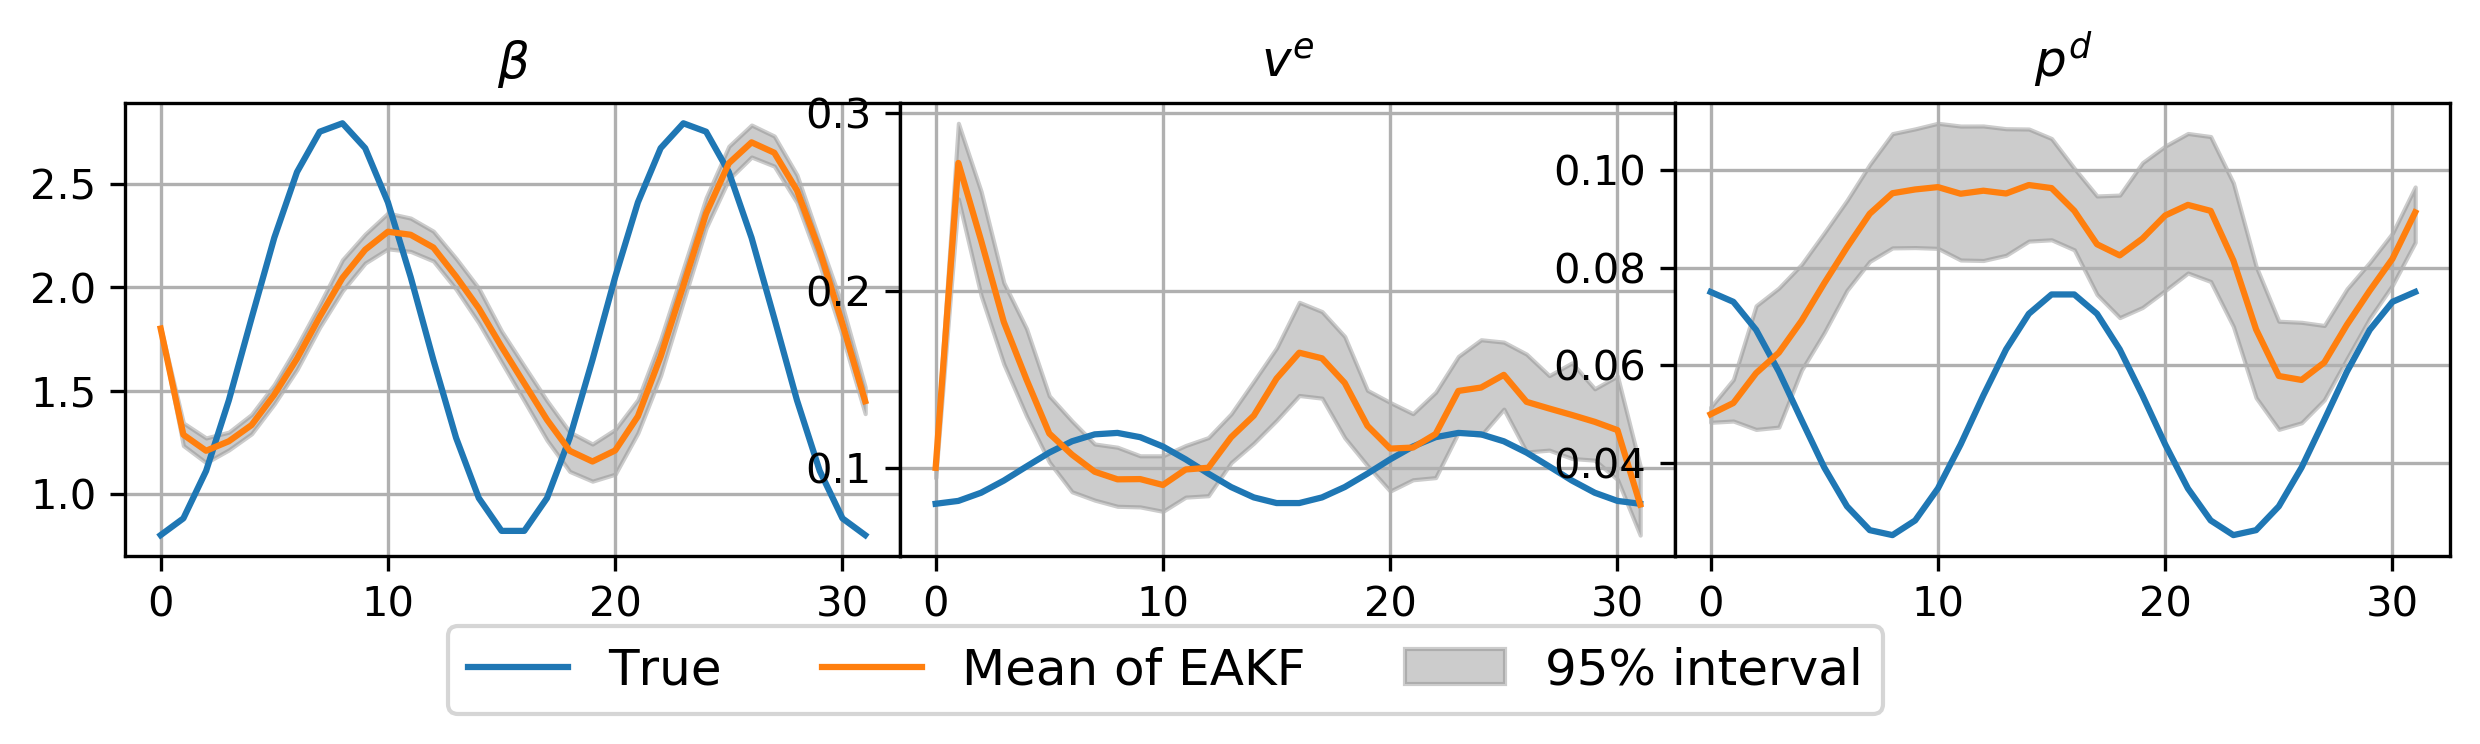

In [30]:
%matplotlib inline
import matplotlib # 注意这个也要import一次
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize # import figsize
#figsize(12.5, 4) # 设置 figsize
plt.rcParams['savefig.dpi'] = 300 #图片像素
plt.rcParams['figure.dpi'] = 300 #分辨率

figsize(10, 2)
plt.subplots_adjust(wspace =0, hspace =0)
x = np.arange(0, 32, 1 / discretization)

ax1 = plt.subplot(1, 3, 1) # 两行一列，位置是1的子图
lower_95 = np.percentile(all_beta, 97.5, axis=0)
upper_95 = np.percentile(all_beta, 2.5, axis=0)

plt.fill_between(x, lower_95, upper_95, color='grey', alpha = 0.4, label='95% interval')
plt.plot(x, true_beta, label='True')
plt.plot(x, np.mean(all_beta, axis=0), label='Mean of EAKF')
plt.title(r'$\beta$')
plt.grid()
plt.legend(bbox_to_anchor=(2.3, -0.1), fontsize=12, ncol=4)

ax2 = plt.subplot(1, 3, 2)
lower_95 = np.percentile(all_ve, 97.5, axis=0)
upper_95 = np.percentile(all_ve, 2.5, axis=0)
plt.fill_between(x, lower_95, upper_95, color='grey', alpha = 0.4)
plt.plot(x, true_ve)
plt.plot(x, np.mean(all_ve, axis=0))
plt.grid()
plt.title(r'$v^e$')


ax3 = plt.subplot(1, 3, 3)
lower_95 = np.percentile(all_pd, 97.5, axis=0)
upper_95 = np.percentile(all_pd, 2.5, axis=0)
plt.fill_between(x, lower_95 / 4, upper_95 / 4, color='grey', alpha = 0.4)
plt.plot(x, true_pd)
plt.plot(x, np.mean(all_pd / 4, axis=0))
plt.title(r'$p^d$')
plt.grid()

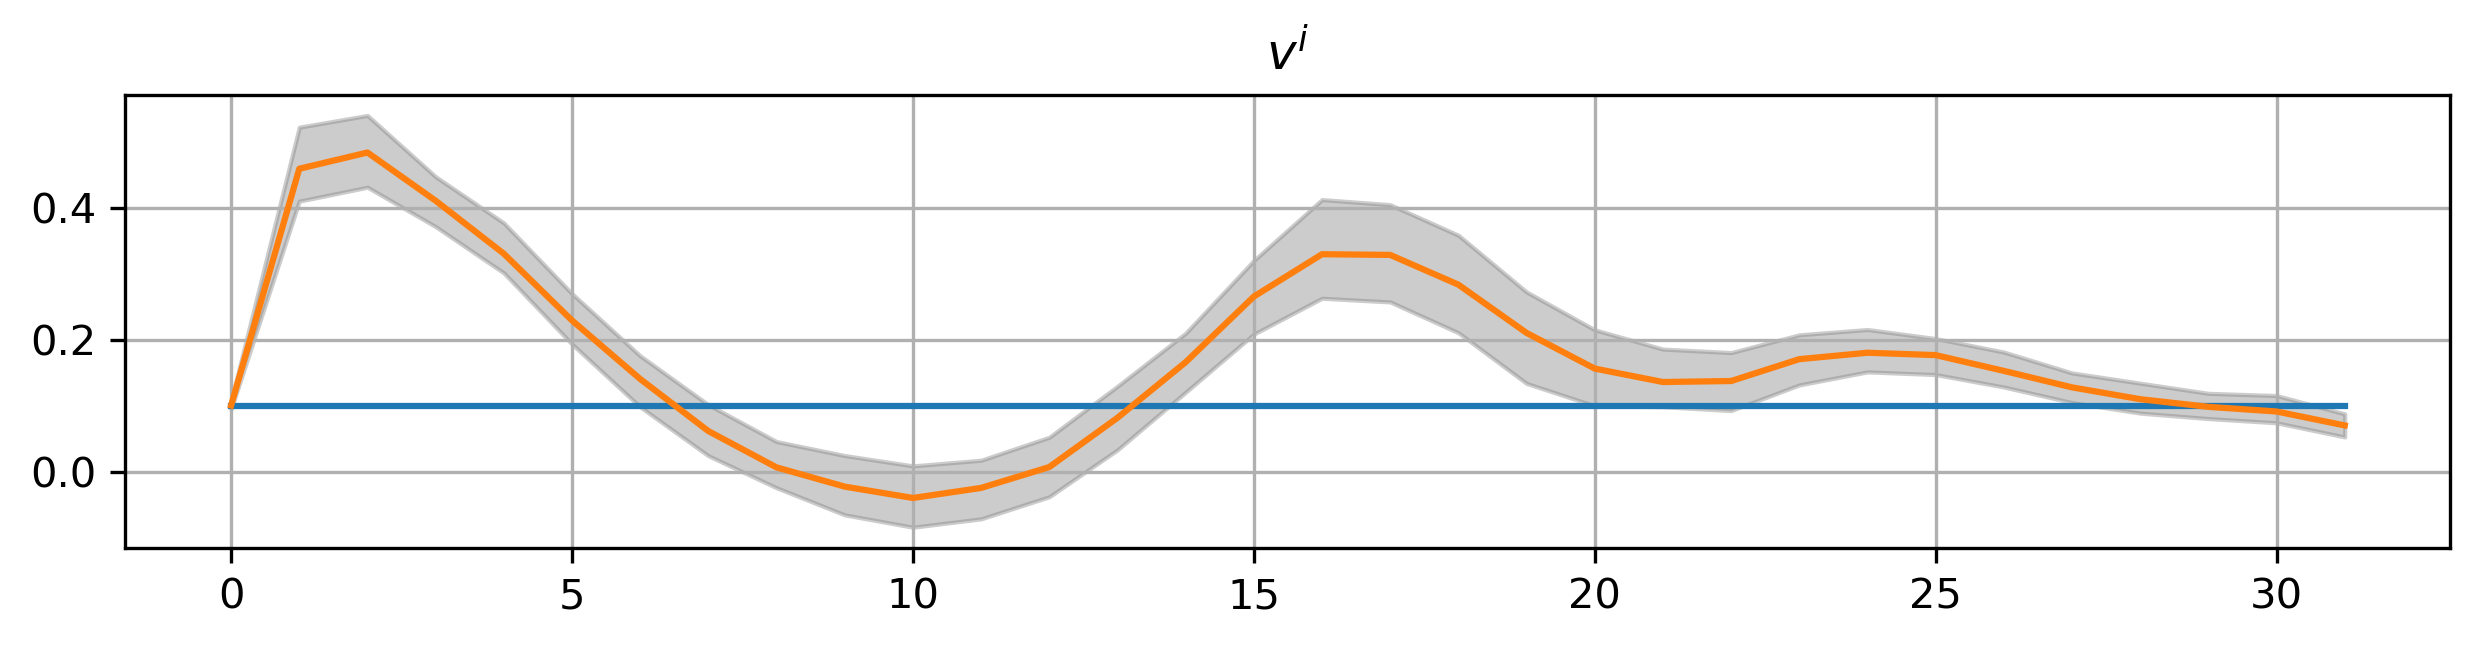

In [31]:
lower_95 = np.percentile(all_vi, 97.5, axis=0)
upper_95 = np.percentile(all_vi, 2.5, axis=0)
plt.fill_between(x, lower_95, upper_95, color='grey', alpha = 0.4)
plt.plot(x, true_vi * np.ones(len(x)))
plt.plot(x, np.mean(all_vi, axis=0))
plt.title(r'$v^i$')
plt.grid()

# Recover data

In [39]:
def recover_data(true_re, true_ve, true_vi, true_pd, days, obs_per_day, state0=[N, 100, 50, 50], linspace=1000):
    """
    params: parameter: [beta, ve, vi, pd]
    """
    # check input
    # [ S, E, I, D, cfr0]
    freq = 1. / discretization
    nFull = days * obs_per_day
    step_size = 1. / (linspace * obs_per_day)
    state_ls = np.ones((nFull * linspace, 4))
    state_ls[0][0] = state0[0]
    state_ls[0][1] = state0[1]
    state_ls[0][2] = state0[2]
    state_ls[0][3] = state0[3]

    for i in range(1, linspace * nFull):
        index = int(i / linspace)
        state_ls[i][0] = state_ls[i - 1][0] - step_size * true_re[index] * state_ls[i - 1][2] * state_ls[i - 1][0] / N
        state_ls[i][1] = state_ls[i - 1][1] + step_size * true_re[index] * state_ls[i - 1][2] * state_ls[i - 1][0] / N - step_size * true_ve[index] * state_ls[i - 1][1]
        state_ls[i][2] = state_ls[i - 1][2] + step_size * true_ve[index] * state_ls[i - 1][1] - step_size * state_ls[i - 1][2] * true_vi[index]
        state_ls[i][3] = state_ls[i - 1][3] + step_size * state_ls[i - 1][2] * true_vi[index] * true_pd[index] / 4
    states = state_ls[::linspace]
    # add noise
    return states



fitted = np.zeros((100, 32, 4))
for i in range(100):
#     print(i)
    fitted[i] = recover_data(all_beta[i], all_ve[i], all_vi[i], all_pd[i], days=32, obs_per_day=1, state0 = [100000, 100, 50, 50])

# True data

In [33]:
def true_data(days=32, obs_per_day=1, state0=[100000., 100., 50., 50.], linspace=1000):
    """
    params: parameter: [beta, ve, vi, pd]
    """
    # check input
    parameter_value = [1.8, 0.1, 0.1, 0.05]
    std = [1., 0.02, 0, 0.025]
    T = 2
    tmp = np.linspace(0, 2 * T * np.pi, 32000)
    true_re = parameter_value[0] - std[0] * np.cos(tmp)
    true_ve = parameter_value[1]- std[1] * np.cos(tmp)
    true_vi = parameter_value[2] 
    true_pd = parameter_value[3] + std[3] * np.cos(tmp)
    nFull = int(days * obs_per_day)
    step_size = 1. / (linspace * obs_per_day)
    state_ls = np.ones((nFull * linspace, 4))
    state_ls[0][0] = state0[0]
    state_ls[0][1] = state0[1]
    state_ls[0][2] = state0[2]
    state_ls[0][3] = state0[3]

    for i in range(1, linspace * nFull):
        index = i - 1
        state_ls[i][0] = state_ls[i - 1][0] - step_size * true_re[index] * state_ls[i - 1][2] * state_ls[i - 1][0] / N
        state_ls[i][1] = state_ls[i - 1][1] + step_size * true_re[index] * state_ls[i - 1][2] * state_ls[i - 1][0] / N - step_size * true_ve[index] * state_ls[i - 1][1]
        state_ls[i][2] = state_ls[i - 1][2] + step_size * true_ve[index] * state_ls[i - 1][1] - step_size * state_ls[i - 1][2] * true_vi
        state_ls[i][3] = state_ls[i - 1][3] + step_size * state_ls[i - 1][2] * true_vi * true_pd[index]
    states = state_ls[::linspace]
    return states

true_x = true_data()

Text(0.5, 1.0, '$D$')

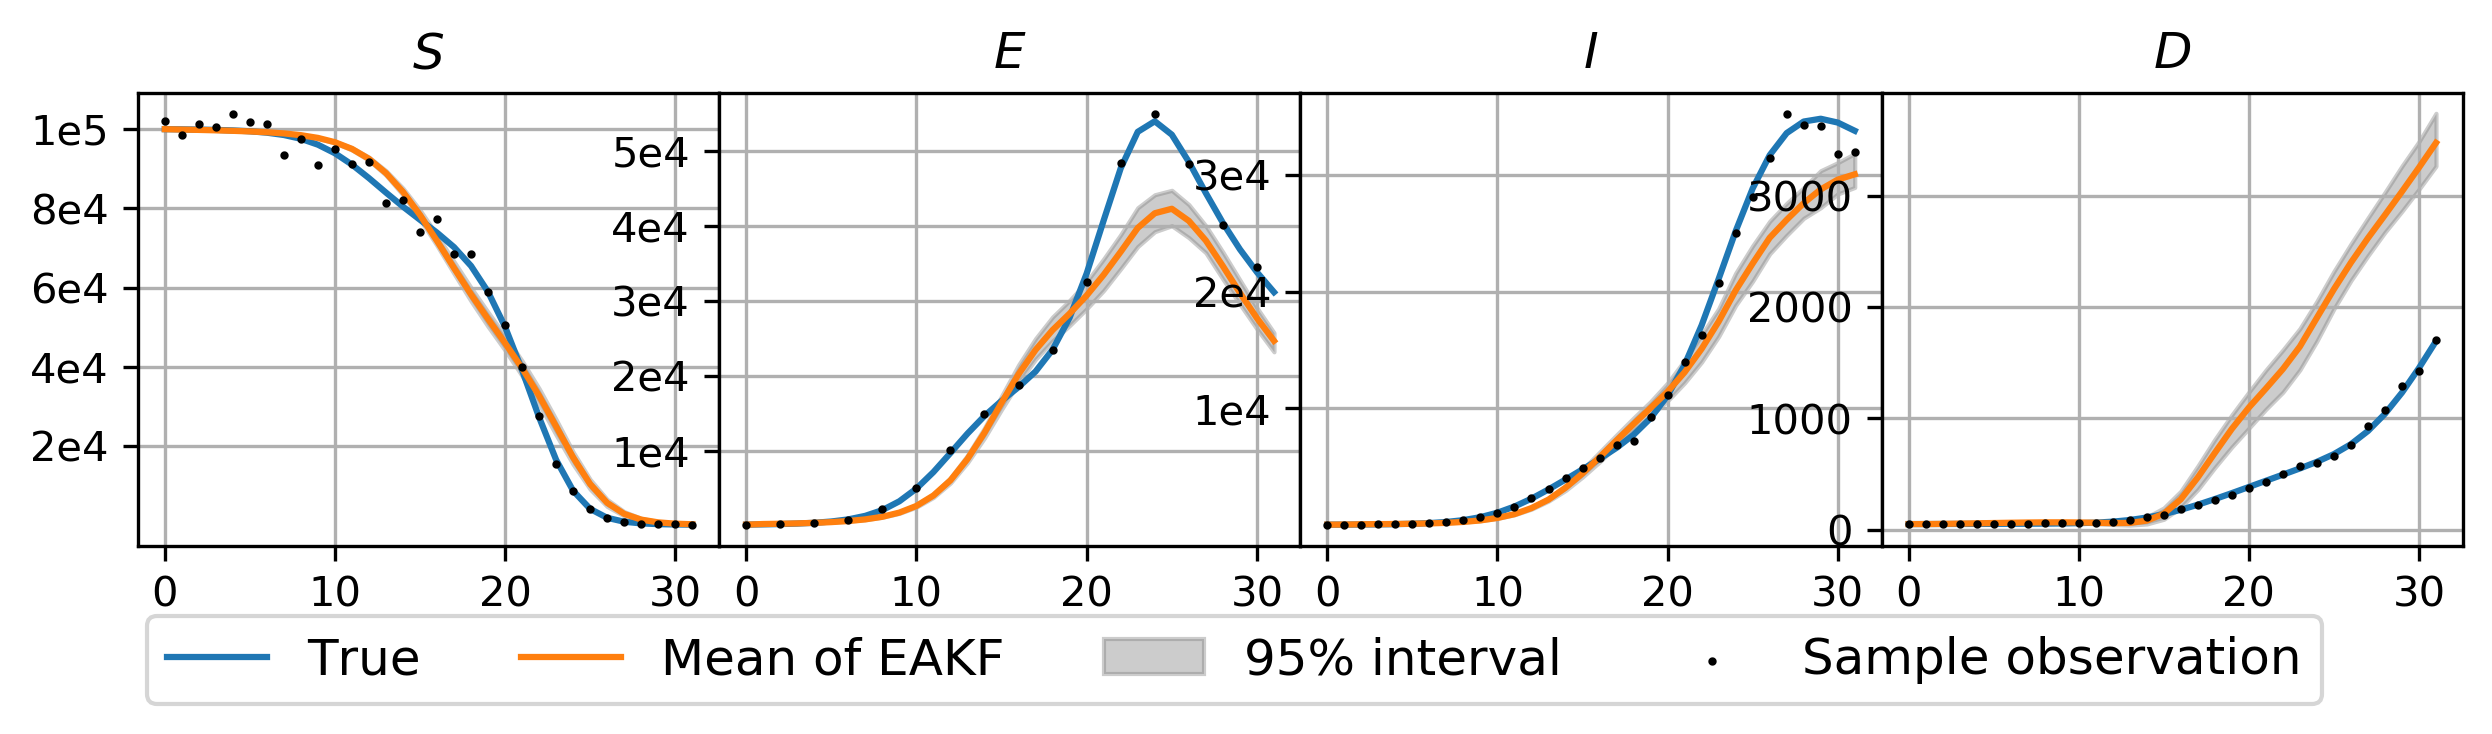

In [44]:
yobs = np.exp(np.load('SEIRD observations.npy')[1])
figsize(10, 2)
plt.subplots_adjust(wspace =0, hspace =0)
ax1 = plt.subplot(1, 4, 1) # 两行一列，位置是1的子图
lower_95 = np.percentile(fitted[:,:, 0], 97.5, axis=0)
upper_95 = np.percentile(fitted[:,:, 0], 2.5, axis=0)
x = np.arange(0, 32, 1 / discretization)
plt.yticks(np.array([20000, 40000, 60000, 80000, 100000]), ['2e4', '4e4', '6e4', '8e4', '1e5'])
plt.fill_between(x, lower_95, upper_95, color='grey', alpha = 0.4, label='95% interval')
plt.plot(true_x[:, 0], label='True')
plt.plot(x, np.mean(fitted[:,:, 0], axis=0), label='Mean of EAKF')
plt.scatter(np.arange(0, 32, 1), yobs[:, 0], s = 1, color='black', label='Sample observation', zorder=100)
plt.grid()
plt.title(r'$S$')
plt.legend(bbox_to_anchor=(3.8, -0.1), fontsize=12, ncol=4)

ax2 = plt.subplot(1, 4, 2)
lower_95 = np.percentile(fitted[:,:, 1], 97.5, axis=0)
upper_95 = np.percentile(fitted[:,:, 1], 2.5, axis=0)
plt.yticks(np.array([10000, 20000, 30000, 40000, 50000]), ['1e4', '2e4', '3e4', '4e4', '5e4'])
plt.fill_between(x, lower_95, upper_95, color='grey', alpha = 0.4)
plt.plot(true_x[:, 1])
plt.plot(x, np.mean(fitted[:,:, 1], axis=0))
plt.scatter(np.arange(0, 32, 1), yobs[:, 1], s = 1, color='black', label='Sample observation', zorder=100)
plt.grid()
plt.title(r'$E$')


ax3 = plt.subplot(1, 4, 3)
lower_95 = np.percentile(fitted[:,:, 2], 95, axis=0)
upper_95 = np.percentile(fitted[:,:, 2], 5, axis=0)
plt.fill_between(x, lower_95, upper_95, color='grey', alpha = 0.4)
plt.yticks(np.array([10000, 20000, 30000]), ['1e4', '2e4', '3e4'])
plt.plot(true_x[:, 2])
plt.plot(x, np.mean(fitted[:,:, 2], axis=0))
plt.scatter(np.arange(0, 32, 1), yobs[:, 2], s = 1, color='black', label='Sample observation', zorder=100)
plt.grid()
plt.title(r'$I$')


ax4= plt.subplot(1, 4, 4)
lower_95 = np.percentile(fitted[:,:, 3], 97.5, axis=0)
upper_95 = np.percentile(fitted[:,:, 3], 2.5, axis=0)
plt.fill_between(x, lower_95, upper_95, color='grey', alpha = 0.4)
plt.plot(true_x[:, 3])
plt.plot(x, np.mean(fitted[:,:, 3], axis=0))
plt.scatter(np.arange(0, 32, 1), yobs[:, 3], s = 1, color='black', label='Sample observation', zorder=100)
plt.grid()
plt.title(r'$D$')

# RMSE

In [41]:
RMSE_S = np.zeros(100)
RMSE_E = np.zeros(100)
RMSE_I = np.zeros(100)
RMSE_D = np.zeros(100)

for i in range(100):
    RMSE_S[i] = np.sqrt(np.mean(np.square(fitted[i, :, 0] - true_x[:, 0])))
    RMSE_E[i] = np.sqrt(np.mean(np.square(fitted[i, :, 1] - true_x[:, 1])))
    RMSE_I[i] = np.sqrt(np.mean(np.square(fitted[i, :, 2] - true_x[:, 2])))
    RMSE_D[i] = np.sqrt(np.mean(np.square(fitted[i, :, 3] - true_x[:, 3])))
print(np.mean(RMSE_S), np.std(RMSE_S))
print(np.mean(RMSE_E), np.std(RMSE_E))
print(np.mean(RMSE_I), np.std(RMSE_I))
print(np.mean(RMSE_D), np.std(RMSE_D))

3868.3294892403774 132.20211411565845
5376.116904357736 496.6785166017599
3167.085116031728 404.98235418473814
907.3280237176472 48.67749846952831


In [42]:
RMSE_beta = np.zeros(100)
RMSE_ve = np.zeros(100)
RMSE_vi = np.zeros(100)
RMSE_pd = np.zeros(100)

for i in range(100):
    RMSE_beta[i] = np.sqrt(np.mean(np.square(all_beta[i] - true_beta)))
    RMSE_ve[i] = np.sqrt(np.mean(np.square(all_ve[i] - true_ve)))
    RMSE_vi[i] = np.sqrt(np.mean(np.square(all_vi[i] - true_vi)))
    RMSE_pd[i] = np.sqrt(np.mean(np.square(all_pd[i]/4 - true_pd)))
    
print(np.mean(RMSE_beta), np.std(RMSE_beta))
print(np.mean(RMSE_ve), np.std(RMSE_ve))
print(np.mean(RMSE_vi), np.std(RMSE_vi))
print(np.mean(RMSE_pd), np.std(RMSE_pd))

0.7060032054467311 0.010172447836133008
0.057962978002711676 0.003291814134631871
0.1518343605188967 0.0075672450822295316
0.03903967820469985 0.0033650459234231475
